<a href="https://colab.research.google.com/github/SawsanYusuf/The_Price_of_Netflix_Stocks/blob/main/NFLX_Stocks_Autoregressive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NFLX Stocks/ Autoregressive Model

In [1]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.4 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [16]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

## 1. Prepare

### 1.1 Import Data

In [3]:
#Get the stock quote
dataset = web.DataReader('NFLX', data_source='yahoo' )
#show the data
dataset

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-10-18,200.009995,194.250000,199.990005,195.539993,11198900,195.539993
2017-10-19,195.250000,191.160004,193.009995,195.130005,7034600,195.130005
2017-10-20,196.380005,193.770004,195.899994,194.160004,5995600,194.160004
2017-10-23,194.899994,191.029999,194.169998,192.470001,6980000,192.470001
2017-10-24,196.740005,191.399994,192.750000,196.020004,7069100,196.020004
...,...,...,...,...,...,...
2022-10-10,233.830002,224.229996,225.639999,229.979996,9991100,229.979996
2022-10-11,230.440002,213.699997,226.050003,214.289993,15282400,214.289993
2022-10-12,223.669998,212.639999,214.300003,220.869995,12952600,220.869995


In [4]:
df = pd.DataFrame(dataset["Close"])
df.head()

,Close
Date,
2017-10-18,195.539993
2017-10-19,195.130005
2017-10-20,194.160004
2017-10-23,192.470001
2017-10-24,196.020004


In [5]:
y = df["Close"]. resample("1D").mean().fillna(method="ffill")
y.head()

Date
2017-10-18    195.539993
2017-10-19    195.130005
2017-10-20    194.160004
2017-10-21    194.160004
2017-10-22    194.160004
Freq: D, Name: Close, dtype: float64

### 1.2 Explore

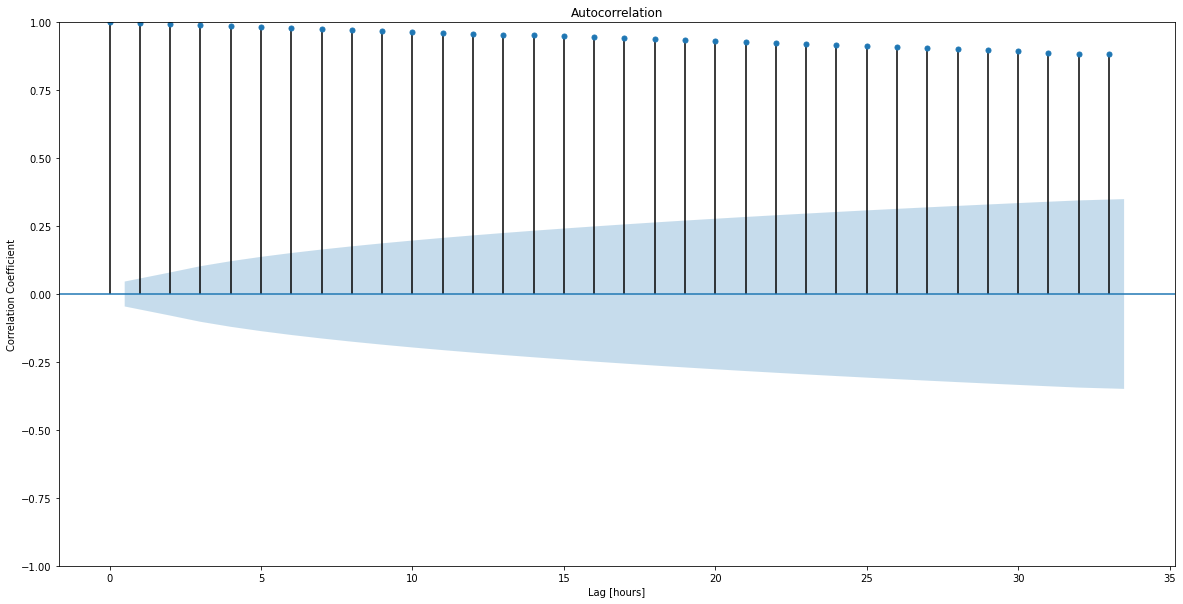

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

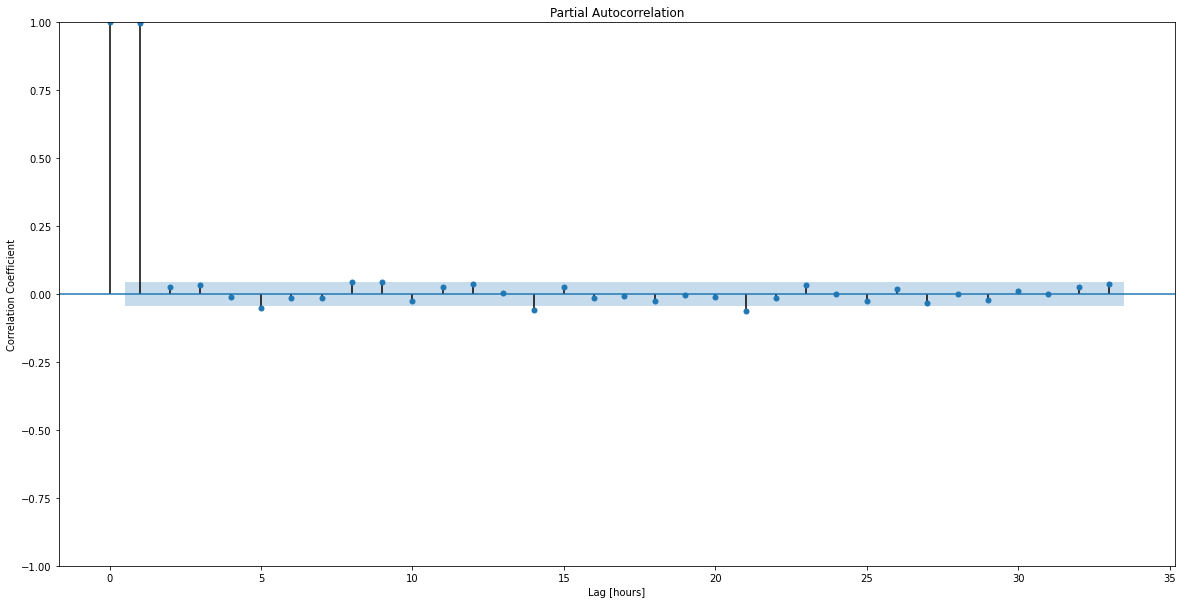

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_pacf(y, ax = ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

### 1.3 Split

In [8]:
cutoff_test = int(len(y) * 0.95)
y_train = y.iloc[: cutoff_test]
y_test = y.iloc[cutoff_test : ]

## 2. Build Model

###2.1 Baseline

In [9]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean Close Price:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Close Price: 391.69
Baseline MAE: 101.55


### 2.2 Iterate

In [50]:
model = AutoReg(y_train, lags = 3).fit()

In [51]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[3:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 5.1810631458948


In [52]:
y_train_resid = model.resid
y_train_resid.tail()

Date
2022-07-10    -0.618563
2022-07-11   -10.137605
2022-07-12    -3.700927
2022-07-13     0.985318
2022-07-14    -2.392823
Freq: D, dtype: float64

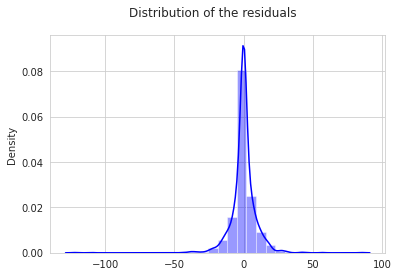

In [53]:
sns.set_style('whitegrid')
plt.suptitle("Distribution of the residuals")
sns.distplot(y_train_resid, color='b', bins = 30, kde = True);

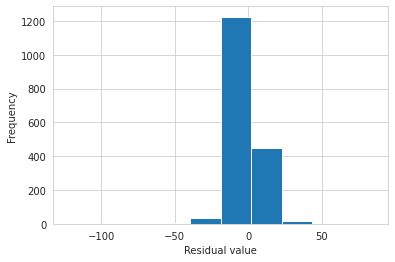

In [38]:
y_train_resid.hist()
plt.xlabel("Residual value")
plt.ylabel("Frequency");

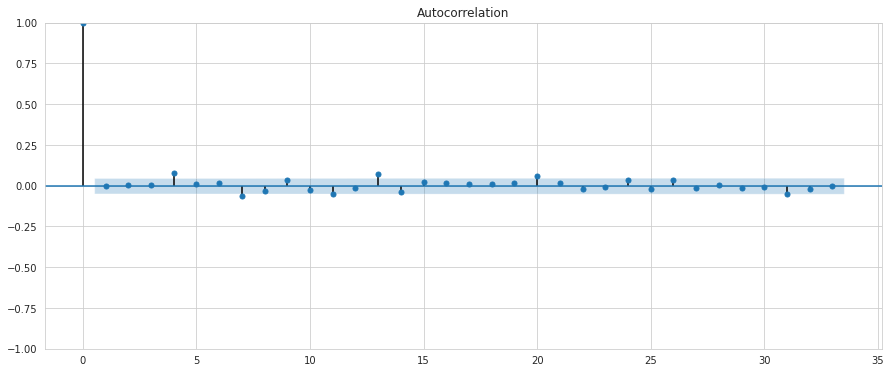

In [54]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

###2.3 Evaluate

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
     model = AutoReg(history, lags=3).fit()
     next_pred = model.forecast()
     y_pred_wfv = y_pred_wfv.append(next_pred)
     history = history.append(y_test[next_pred.index])

In [56]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 4.31


## 3. Results

In [57]:
print(model.params)

const       1.072636
Close.L1    0.965120
Close.L2   -0.021034
Close.L3    0.053177
dtype: float64


In [58]:
df_pred_test = pd.DataFrame(
{"y_test": y_test, "y_pred_wfv": y_pred_wfv})
df_pred_test.head()

,y_test,y_pred_wfv
2022-07-15,189.110001,175.249914
2022-07-16,189.110001,189.296268
2022-07-17,189.110001,188.880550
2022-07-18,190.919998,189.634306
2022-07-19,201.630005,191.387840


In [59]:
fig = px.line(df_pred_test, labels = {"value": "Adj Close Price"})
fig.show()